In [1]:
#Download GLOVE
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-04-17 04:20:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-17 04:20:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  3.80MB/s    in 6m 9s   

2019-04-17 04:26:38 (2.23 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
#!pip install --upgrade pandas
import matplotlib.pyplot as plt
import zipfile,requests,csv
from IPython.display import Image,display
import pandas as pd
import numpy as np
from keras.preprocessing.text import text_to_word_sequence
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential,Model
from keras.layers import Input, Dense
from keras.utils.vis_utils import plot_model
import keras.layers
from sklearn.preprocessing import StandardScaler
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder

In [0]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r--', label="Train Loss")
    ax.legend()
    ax.set_title('mean_squared_error')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r--', label="Train Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

In [5]:
unused_cols = ['annotator_labels','genre','pairID','promptID',
               'sentence1_binary_parse','sentence1_parse',
               'sentence2_binary_parse','sentence2_parse']
url = 'https://raw.githubusercontent.com/Nydhal/nlp/master/'

dev = pd.read_json(requests.get(url+'dev(1)(1).jsonl').content, lines=True)
dev.drop(columns=unused_cols, inplace=True)
print('dev json loaded.',dev.shape)

train = pd.read_json(requests.get(url+'train(1)(1).jsonl').content, lines=True)
train.drop(columns=unused_cols, inplace=True)
print('train json loaded.',train.shape)

test = pd.read_json(requests.get(url+'test(1)(1).jsonl').content, lines=True)
test.drop(columns=unused_cols, inplace=True)
test = test[test.gold_label != '-']
print('test json loaded.',test.shape)

f = open('glove.6B.50d.txt')
glove = {line.split()[0]:np.asarray(line.split()[1:], dtype='float32')\
         for line in f}     
f.close()

print('Found %s word vectors.' % len(glove))
print('Glove Loaded to dictionary.')

dev json loaded. (1000, 3)
train json loaded. (10000, 3)
test json loaded. (990, 3)
Found 400000 word vectors.
Glove Loaded to dictionary.


In [6]:
# takes string returns sentence glove embedding
def str2vec(str):
  word_list = text_to_word_sequence(str)
  word_list += [''] * (15 - len(word_list))
  vect_list = [glove.get(word,np.zeros(50)) for word in word_list]
  return np.concatenate(vect_list, axis=0 )

dev_prem = np.vstack([str2vec(s) for s in dev  ['sentence1']])
print(dev_prem.shape,end=' ')
dev_hypo = np.vstack([str2vec(s) for s in dev  ['sentence2']])
print(dev_hypo.shape,end=' ')
dev_labl = pd.get_dummies(dev  ['gold_label']).to_numpy()
print(dev_labl.shape)

trn_prem = np.vstack([str2vec(s) for s in train['sentence1']])
print(trn_prem.shape,end=' ')
trn_hypo = np.vstack([str2vec(s) for s in train['sentence2']])
print(trn_hypo.shape,end=' ')
trn_labl = pd.get_dummies(train['gold_label']).to_numpy()
print(trn_labl.shape)

tst_prem = np.vstack([str2vec(s) for s in test ['sentence1']])
print(tst_prem.shape,end=' ')
tst_hypo = np.vstack([str2vec(s) for s in test ['sentence2']])
print(tst_hypo.shape,end=' ')
tst_labl = pd.get_dummies(test ['gold_label']).to_numpy()
print(tst_labl.shape)

(1000, 750) (1000, 750) (1000, 3)
(10000, 750) (10000, 750) (10000, 3)
(990, 750) (990, 750) (990, 3)


In [24]:
#model 1
pre_inputs = Input(shape=(750,))
x = Dense(750, activation='relu')(pre_inputs)
x = Dense(500, activation='relu')(x)
x = Dense(100, activation='sigmoid')(x)

premise_output = x

hyp_inputs = Input(shape=(750,))
y = Dense(750, activation='relu')(hyp_inputs)
y = Dense(500, activation='relu')(y)
y = Dense(100, activation='sigmoid')(y)

hypothesis_output = y

g = keras.layers.concatenate([premise_output, hypothesis_output])

g = Dense(200, activation='relu')(g)
g = Dense(100, activation='relu')(g)
main_output = Dense(3, activation='relu', name='main_output')(g)

model = Model(inputs=[pre_inputs,hyp_inputs], outputs=[main_output])
opt = optimizers.SGD(lr=0.02, decay=1e-2, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='mean_squared_error', loss_weights=[0.6], metrics=['accuracy'])

# Model summary
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 750)          563250      input_21[0][0]                   
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 750)          563250      input_22[0][0]                   
__________________________________________________________________________________________________
dense_67 (

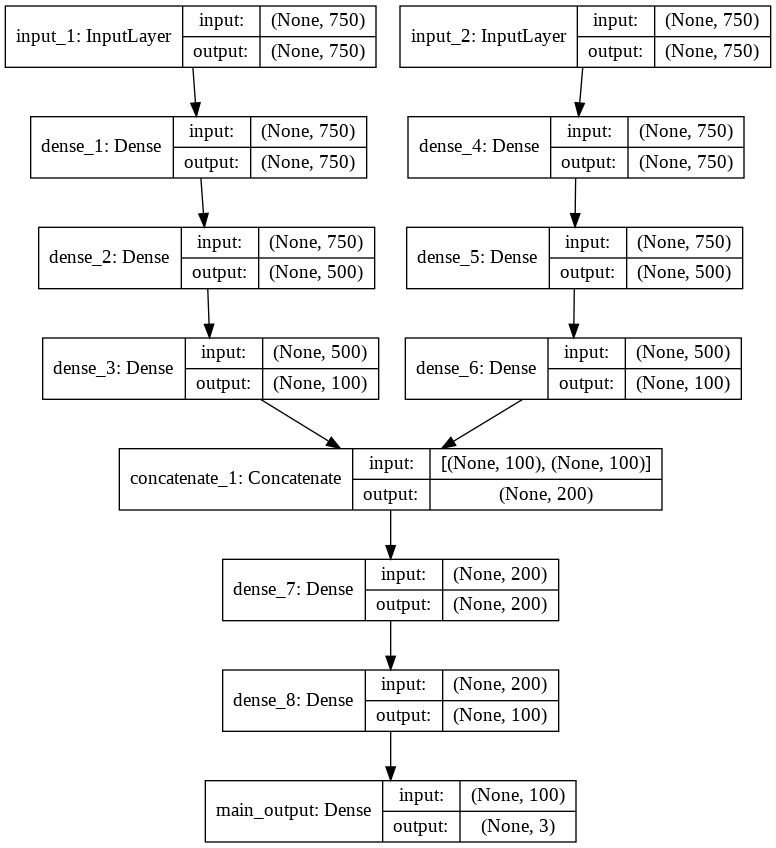

In [8]:
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [12]:
history = model.fit([trn_prem, trn_hypo], trn_labl,epochs=50, batch_size=20,verbose=0)

Epoch 1/20
10000/10000 [==============================] - 8s 834us/step - loss: 0.1571 - acc: 0.3985
Epoch 2/20
10000/10000 [==============================] - 9s 884us/step - loss: 0.1571 - acc: 0.3975
Epoch 3/20
10000/10000 [==============================] - 9s 887us/step - loss: 0.1570 - acc: 0.3997
Epoch 4/20
10000/10000 [==============================] - 9s 878us/step - loss: 0.1569 - acc: 0.4004
Epoch 5/20
10000/10000 [==============================] - 9s 891us/step - loss: 0.1569 - acc: 0.4008
Epoch 6/20
10000/10000 [==============================] - 9s 860us/step - loss: 0.1569 - acc: 0.4008
Epoch 7/20
10000/10000 [==============================] - 9s 860us/step - loss: 0.1568 - acc: 0.4032
Epoch 8/20
10000/10000 [==============================] - 8s 841us/step - loss: 0.1568 - acc: 0.4002
Epoch 9/20
10000/10000 [==============================] - 9s 862us/step - loss: 0.1567 - acc: 0.4009
Epoch 10/20
10000/10000 [==============================] - 9s 867us/step - loss: 0.1567 - a

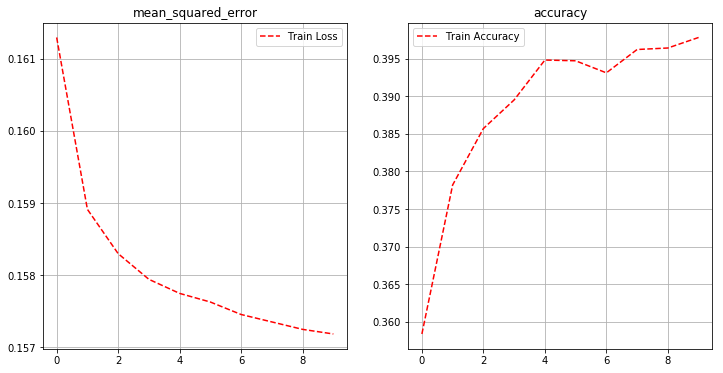

In [10]:
plot_loss_accuracy(history)

In [11]:
model.evaluate(x=[tst_prem, tst_hypo], y=tst_labl)

990/990 [==============================] - 0s 200us/step


[0.15327141134425848, 0.39696969781259095]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 750)          563250      input_23[0][0]                   
__________________________________________________________________________________________________
dense_77 (Dense)                (None, 750)          563250      input_24[0][0]                   
__________________________________________________________________________________________________
dense_75 (

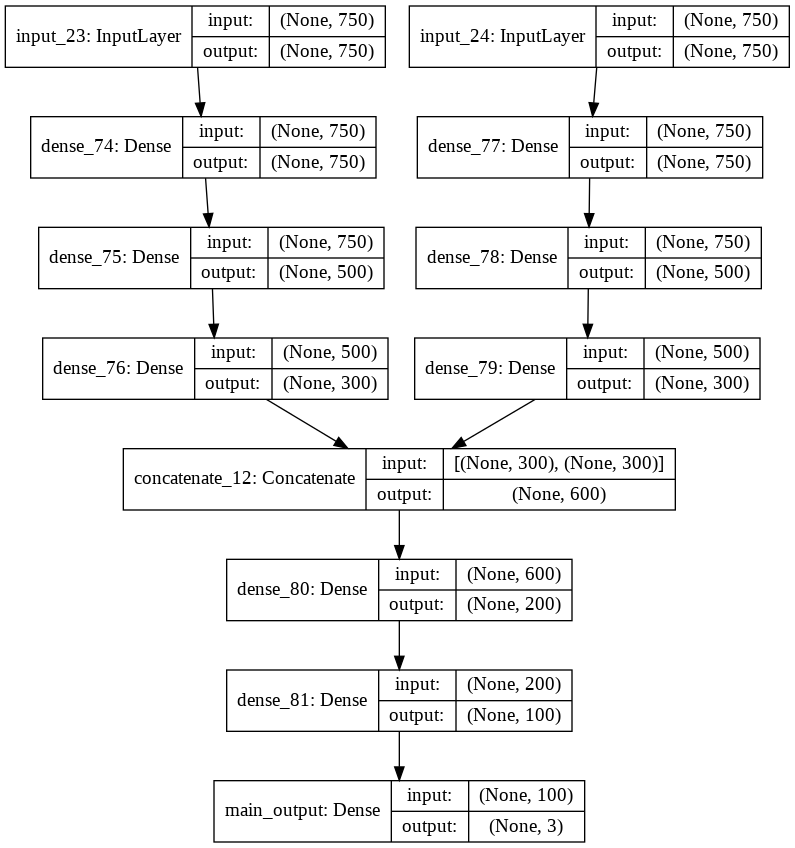

Epoch 1/50
10000/10000 [==============================] - 12s 1ms/step - loss: 0.1468 - acc: 0.3733
Epoch 2/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1450 - acc: 0.3845
Epoch 3/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1447 - acc: 0.3943
Epoch 4/50
10000/10000 [==============================] - 12s 1ms/step - loss: 0.1443 - acc: 0.3925
Epoch 5/50
10000/10000 [==============================] - 12s 1ms/step - loss: 0.1440 - acc: 0.3996
Epoch 6/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1439 - acc: 0.4003
Epoch 7/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1439 - acc: 0.3995
Epoch 8/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1438 - acc: 0.4018
Epoch 9/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1437 - acc: 0.4063
Epoch 10/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1436 - acc: 0.4041

[0.14599537987901706, 0.38686868729013385]

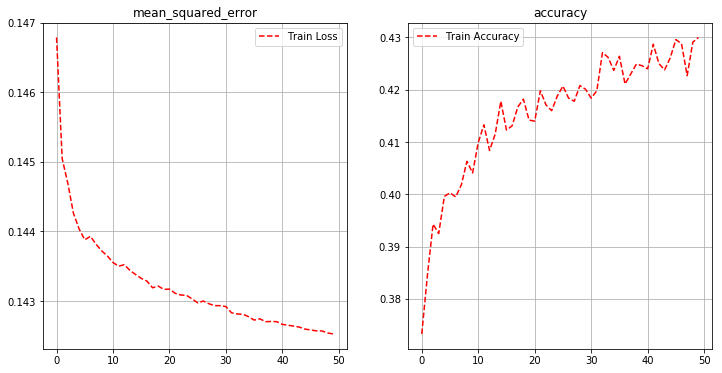

In [25]:
#model 2 (300,100)
pre_inputs = Input(shape=(750,))
x = Dense(750, activation='relu')(pre_inputs)
x = Dense(500, activation='relu')(x)
x = Dense(300, activation='sigmoid')(x)

premise_output = x

hyp_inputs = Input(shape=(750,))
y = Dense(750, activation='relu')(hyp_inputs)
y = Dense(500, activation='relu')(y)
y = Dense(300, activation='sigmoid')(y)

hypothesis_output = y

g = keras.layers.concatenate([premise_output, hypothesis_output])

g = Dense(200, activation='relu')(g)
g = Dense(100, activation='relu')(g)
main_output = Dense(3, activation='relu', name='main_output')(g)

model = Model(inputs=[pre_inputs,hyp_inputs], outputs=[main_output])
opt = optimizers.SGD(lr=0.02, decay=1e-2, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='mean_squared_error', loss_weights=[0.6], metrics=['accuracy'])

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image(retina=True, filename='model.png'))

history = model.fit([trn_prem, trn_hypo], trn_labl,epochs=50, batch_size=20,verbose=0)
plot_loss_accuracy(history)
model.evaluate(x=[tst_prem, tst_hypo], y=tst_labl)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 750)          563250      input_25[0][0]                   
__________________________________________________________________________________________________
dense_85 (Dense)                (None, 750)          563250      input_26[0][0]                   
__________________________________________________________________________________________________
dense_83 (

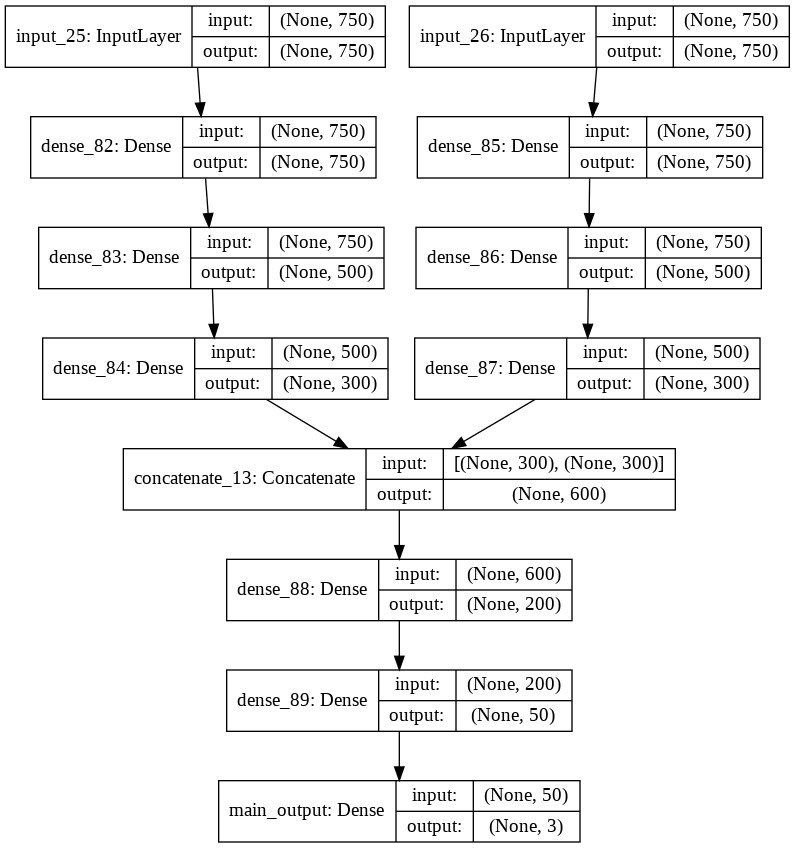

Epoch 1/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1732 - acc: 0.3806
Epoch 2/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1708 - acc: 0.3816
Epoch 3/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1705 - acc: 0.3816
Epoch 4/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1704 - acc: 0.3816
Epoch 5/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1704 - acc: 0.3816
Epoch 6/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1703 - acc: 0.3816
Epoch 7/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1702 - acc: 0.3816
Epoch 8/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1702 - acc: 0.3816
Epoch 9/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1701 - acc: 0.3816
Epoch 10/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1701 - acc: 0.3816

[0.17533878921860396, 0.34848484878588204]

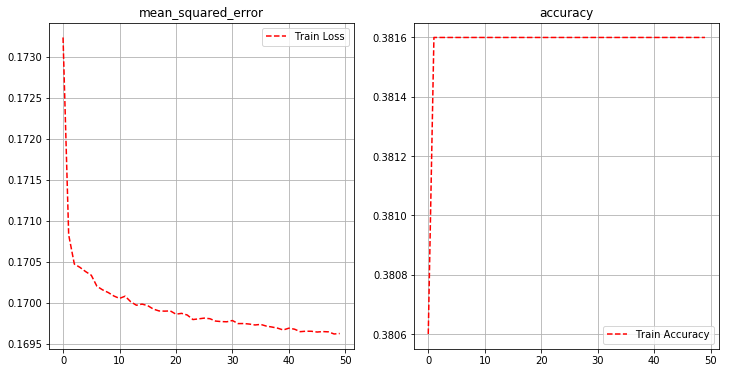

In [26]:
pre_inputs = Input(shape=(750,))
x = Dense(750, activation='relu')(pre_inputs)
x = Dense(500, activation='relu')(x)
x = Dense(300, activation='sigmoid')(x)

premise_output = x

hyp_inputs = Input(shape=(750,))
y = Dense(750, activation='relu')(hyp_inputs)
y = Dense(500, activation='relu')(y)
y = Dense(300, activation='sigmoid')(y)

hypothesis_output = y

g = keras.layers.concatenate([premise_output, hypothesis_output])

g = Dense(200, activation='relu')(g)
g = Dense(50, activation='relu')(g)
main_output = Dense(3, activation='relu', name='main_output')(g)

model = Model(inputs=[pre_inputs,hyp_inputs], outputs=[main_output])
opt = optimizers.SGD(lr=0.02, decay=1e-2, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='mean_squared_error', loss_weights=[0.6], metrics=['accuracy'])

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image(retina=True, filename='model.png'))

history = model.fit([trn_prem, trn_hypo], trn_labl,epochs=50, batch_size=20,verbose=0)
plot_loss_accuracy(history)
model.evaluate(x=[tst_prem, tst_hypo], y=tst_labl)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 750)          0                                            
__________________________________________________________________________________________________
dense_90 (Dense)                (None, 750)          563250      input_27[0][0]                   
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 750)          563250      input_28[0][0]                   
__________________________________________________________________________________________________
dense_91 (

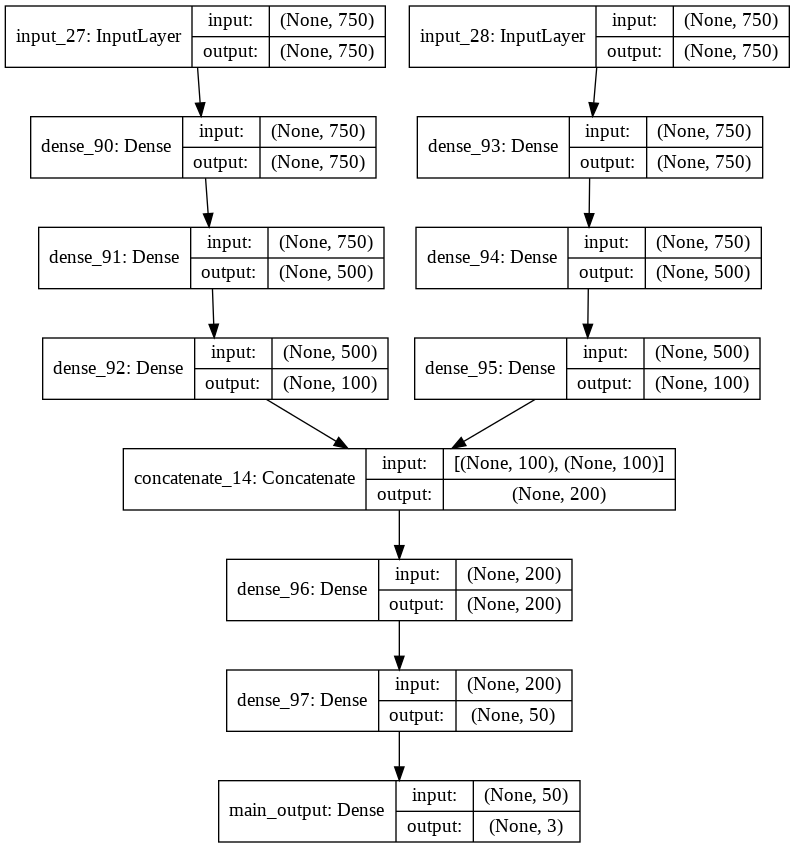

Epoch 1/50
10000/10000 [==============================] - 10s 960us/step - loss: 0.1321 - acc: 0.3832
Epoch 2/50
10000/10000 [==============================] - 9s 905us/step - loss: 0.1289 - acc: 0.4003
Epoch 3/50
10000/10000 [==============================] - 9s 913us/step - loss: 0.1282 - acc: 0.4156
Epoch 4/50
10000/10000 [==============================] - 10s 957us/step - loss: 0.1277 - acc: 0.4271
Epoch 5/50
10000/10000 [==============================] - 10s 996us/step - loss: 0.1275 - acc: 0.4304
Epoch 6/50
10000/10000 [==============================] - 10s 966us/step - loss: 0.1272 - acc: 0.4327
Epoch 7/50
10000/10000 [==============================] - 10s 974us/step - loss: 0.1270 - acc: 0.4303
Epoch 8/50
10000/10000 [==============================] - 10s 975us/step - loss: 0.1268 - acc: 0.4453
Epoch 9/50
10000/10000 [==============================] - 10s 965us/step - loss: 0.1268 - acc: 0.4423
Epoch 10/50
10000/10000 [==============================] - 10s 976us/step - loss: 0.

[0.12751159993084996, 0.4353535353535353]

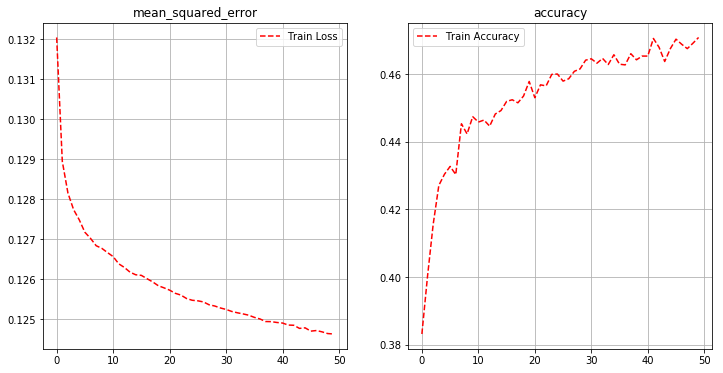

In [27]:
pre_inputs = Input(shape=(750,))
x = Dense(750, activation='relu')(pre_inputs)
x = Dense(500, activation='relu')(x)
x = Dense(100, activation='sigmoid')(x)

premise_output = x

hyp_inputs = Input(shape=(750,))
y = Dense(750, activation='relu')(hyp_inputs)
y = Dense(500, activation='relu')(y)
y = Dense(100, activation='sigmoid')(y)

hypothesis_output = y

g = keras.layers.concatenate([premise_output, hypothesis_output])

g = Dense(200, activation='relu')(g)
g = Dense(50, activation='relu')(g)
main_output = Dense(3, activation='relu', name='main_output')(g)

model = Model(inputs=[pre_inputs,hyp_inputs], outputs=[main_output])
opt = optimizers.SGD(lr=0.02, decay=1e-2, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='mean_squared_error', loss_weights=[0.6], metrics=['accuracy'])

# Model summary
print(model.summary())

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image(retina=True, filename='model.png'))

history = model.fit([trn_prem, trn_hypo], trn_labl,epochs=50, batch_size=20,verbose=0)
plot_loss_accuracy(history)
model.evaluate(x=[tst_prem, tst_hypo], y=tst_labl)

In [29]:
print('Dev Accuracy')
model.evaluate(x=[dev_prem, dev_hypo], y=dev_labl)

Dev Accuracy
1000/1000 [==============================] - 0s 160us/step


[0.12761285018920898, 0.419]

|train accuracy| f=100| f=300|
|---|---|---|
|g=100|0.4034|0.4300|
|g=50|0.4708|0.3816|

--

|test accuracy| f=100| f=300|
|---|---|---|
|g=100|0.3969|0.3868|
|g=50|0.4354|0.3485|